In [1]:
#### Keras implementation of NN's which we will look at MNIST with

from __future__ import print_function
import keras 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import tensorflow as tf
#import tensorflow_datasets as tfds
import scipy
import h5py
import os
from matplotlib import pyplot as plt
import numpy as np
svhn_path="../Datasets/svhn"#"/Home/Adam/Research/Datasets/svhn"
# Hyper-parameters data-loading and formatting

batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 32, 32

In [2]:
## import svhn_cropped which is svhn in 32x32 size

# Open the file as readonly
h5f = h5py.File('SVHN_gray.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
Y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
Y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
Y_val = h5f['y_val'][:]

# Close this file
h5f.close()

print('Training set', X_train.shape, Y_train.shape)
print('Validation set', X_val.shape, Y_val.shape)
print('Test set', X_test.shape, Y_test.shape)


Training set (58605, 32, 32, 1) (58605, 10)
Validation set (14652, 32, 32, 1) (14652, 10)
Test set (26032, 32, 32, 1) (26032, 10)


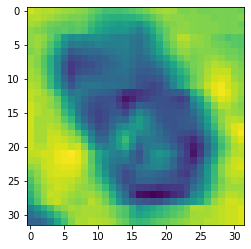

In [3]:
plt.imshow(X_test[305]) 

In [4]:
## import mnist
(x_train, lbl_train), (x_test, lbl_test) = mnist.load_data()

x_train = np.pad(x_train,((0,0),(2,2),(2,2))) #padding to make images 32x32 and not 28x28
x_test = np.pad(x_test,((0,0),(2,2),(2,2))) 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## normalising
x_train /= 255.0 
x_test /= 255.0

## make labels into categorical classes
y_train = keras.utils.to_categorical(lbl_train, num_classes)
y_test = keras.utils.to_categorical(lbl_test, num_classes)


x_train=np.expand_dims(x_train,3)
x_test=np.expand_dims(x_test,3)


In [15]:
## implement LeNet-5 architecture
def init_model():
    model = Sequential()
    model.add(Conv2D(6,(5,5),strides=(1,1), activation='tanh',input_shape=(32,32,1))) ## 6 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(16,(5,5),strides=(1,1), activation='tanh')) ## 16 5x5 conv kernels
    model.add(AveragePooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh'))
    model.add(Flatten())
    #model.add(Dense(120, activation='tanh'))  #equivalent to the last conv2d above?
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax')) # output layer
    return model

In [9]:
## shamelessly taken from : https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras

## Custom callback to be able to evaluate and save the results from several validation sets during training
class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [2, 3]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for i, result in enumerate(results):
                
                if i == 0:
                    valuename = validation_set_name + '_loss'
                else:
                    valuename = validation_set_name + '_' + self.model.metrics[i].name
                self.history.setdefault(valuename, []).append(result)

In [17]:
total_epochs=5


history = AdditionalValidationSets([(X_test, Y_test, 'target_val')])#(X_train, Y_train, 'svhn_train')
histories=[]
iterations=10


### MNIST -> SVHN
for i in range(iterations):
    model=init_model()
    ## choose loss function, optimiser etc. and train
    model.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.1),
        metrics=['accuracy'],)

    fit_info = model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(x_test, y_test),
           callbacks=[history])
    histories.append(history.history)



Epoch 1/2
469/469 [==============================] - 70s 148ms/step - loss: 0.7408 - accuracy: 0.7906 - val_loss: 0.2120 - val_accuracy: 0.9346
Epoch 2/2
469/469 [==============================] - 69s 148ms/step - loss: 0.1902 - accuracy: 0.9429 - val_loss: 0.1188 - val_accuracy: 0.9637
Epoch 1/2
469/469 [==============================] - 70s 149ms/step - loss: 0.7370 - accuracy: 0.7983 - val_loss: 0.2097 - val_accuracy: 0.9381
Epoch 2/2
469/469 [==============================] - 70s 149ms/step - loss: 0.1891 - accuracy: 0.9434 - val_loss: 0.1171 - val_accuracy: 0.9660


Epoch 1/10
469/469 [==============================] - 71s 150ms/step - loss: 0.7464 - accuracy: 0.7983 - val_loss: 0.1967 - val_accuracy: 0.9418
Epoch 2/10
469/469 [==============================] - 69s 148ms/step - loss: 0.1836 - accuracy: 0.9457 - val_loss: 0.1172 - val_accuracy: 0.9671
Epoch 3/10
469/469 [==============================] - 70s 150ms/step - loss: 0.1173 - accuracy: 0.9659 - val_loss: 0.0878 - val_accuracy: 0.9730
Epoch 4/10
469/469 [==============================] - 68s 144ms/step - loss: 0.0843 - accuracy: 0.9748 - val_loss: 0.0728 - val_accuracy: 0.9778
Epoch 5/10
469/469 [==============================] - 70s 149ms/step - loss: 0.0640 - accuracy: 0.9814 - val_loss: 0.0618 - val_accuracy: 0.9815
Epoch 6/10
469/469 [==============================] - 71s 152ms/step - loss: 0.0540 - accuracy: 0.9841 - val_loss: 0.0506 - val_accuracy: 0.9839
Epoch 7/10
469/469 [==============================] - 68s 144ms/step - loss: 0.0492 - accuracy: 0.9857 - val_loss: 0.0479 - val_ac

469/469 [==============================] - 70s 149ms/step - loss: 0.0504 - accuracy: 0.9843 - val_loss: 0.0465 - val_accuracy: 0.9856
Epoch 8/10
469/469 [==============================] - 68s 146ms/step - loss: 0.0431 - accuracy: 0.9871 - val_loss: 0.0508 - val_accuracy: 0.9834
Epoch 9/10
469/469 [==============================] - 70s 149ms/step - loss: 0.0416 - accuracy: 0.9880 - val_loss: 0.0418 - val_accuracy: 0.9873
Epoch 10/10
469/469 [==============================] - 68s 146ms/step - loss: 0.0352 - accuracy: 0.9900 - val_loss: 0.0407 - val_accuracy: 0.9870
Epoch 1/10
469/469 [==============================] - 69s 147ms/step - loss: 0.7646 - accuracy: 0.7856 - val_loss: 0.1975 - val_accuracy: 0.9415
Epoch 2/10
469/469 [==============================] - 69s 146ms/step - loss: 0.1888 - accuracy: 0.9422 - val_loss: 0.1320 - val_accuracy: 0.9579
Epoch 3/10
469/469 [==============================] - 68s 146ms/step - loss: 0.1213 - accuracy: 0.9644 - val_loss: 0.1093 - val_accuracy: 0.

458/458 [==============================] - 67s 146ms/step - loss: 2.1290 - accuracy: 0.2641 - val_loss: 2.0725 - val_accuracy: 0.3354
Epoch 4/10
458/458 [==============================] - 68s 148ms/step - loss: 1.3186 - accuracy: 0.5963 - val_loss: 0.8110 - val_accuracy: 0.7485
Epoch 5/10
458/458 [==============================] - 68s 148ms/step - loss: 0.6993 - accuracy: 0.7888 - val_loss: 0.6768 - val_accuracy: 0.7924
Epoch 6/10
458/458 [==============================] - 67s 146ms/step - loss: 0.5787 - accuracy: 0.8258 - val_loss: 0.5670 - val_accuracy: 0.8291
Epoch 7/10
458/458 [==============================] - 67s 146ms/step - loss: 0.5033 - accuracy: 0.8489 - val_loss: 0.5283 - val_accuracy: 0.8426
Epoch 8/10
458/458 [==============================] - 68s 148ms/step - loss: 0.4547 - accuracy: 0.8630 - val_loss: 0.5213 - val_accuracy: 0.8453
Epoch 9/10
458/458 [==============================] - 68s 149ms/step - loss: 0.4191 - accuracy: 0.8758 - val_loss: 0.5099 - val_accuracy: 0.8

458/458 [==============================] - 68s 149ms/step - loss: 0.4261 - accuracy: 0.8722 - val_loss: 0.5023 - val_accuracy: 0.8489
Epoch 10/10
458/458 [==============================] - 66s 144ms/step - loss: 0.4112 - accuracy: 0.8763 - val_loss: 0.5781 - val_accuracy: 0.8260
Epoch 1/10
458/458 [==============================] - 69s 150ms/step - loss: 2.2418 - accuracy: 0.1874 - val_loss: 2.2214 - val_accuracy: 0.1990
Epoch 2/10
458/458 [==============================] - 66s 144ms/step - loss: 2.2142 - accuracy: 0.2052 - val_loss: 2.1571 - val_accuracy: 0.2401
Epoch 3/10
458/458 [==============================] - 67s 146ms/step - loss: 2.0804 - accuracy: 0.2852 - val_loss: 1.6414 - val_accuracy: 0.4809
Epoch 4/10
458/458 [==============================] - 67s 146ms/step - loss: 1.4738 - accuracy: 0.5266 - val_loss: 1.0611 - val_accuracy: 0.6827
Epoch 5/10
458/458 [==============================] - 69s 150ms/step - loss: 0.9342 - accuracy: 0.7158 - val_loss: 0.8300 - val_accuracy: 0.

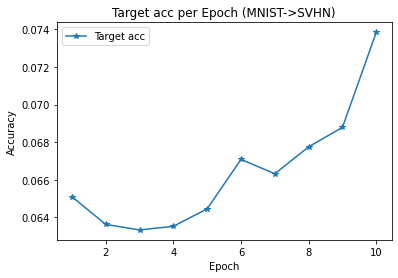

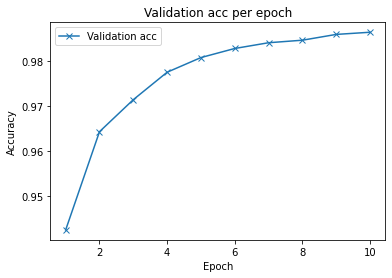

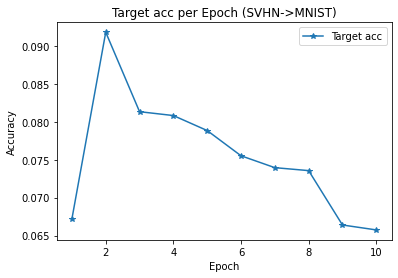

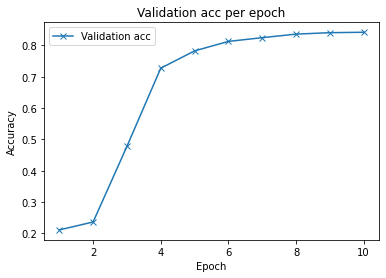

In [32]:
### test for both datasets, to run overnight
total_epochs=10

history = AdditionalValidationSets([(X_test, Y_test, 'target_val')])#(X_train, Y_train, 'svhn_train')
histories=[]
iterations=10


### MNIST -> SVHN
for i in range(iterations):
    model=init_model()
    ## choose loss function, optimiser etc. and train
    model.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.1),
        metrics=['accuracy'],)

    fit_info = model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(x_test, y_test),
           callbacks=[history])
    histories.append(history.history)
    
    
    
history = AdditionalValidationSets([(x_test, y_test, 'target_val')])
histories2=[]


### SVHN -> MNIST
for i in range(iterations):
    model=init_model()
    ## choose loss function, optimiser etc. and train
    model.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.SGD(learning_rate=0.1),
        metrics=['accuracy'],)


    fit_info = model.fit(X_train, Y_train,
           batch_size=batch_size,
           epochs=total_epochs,
           verbose=1,
           validation_data=(X_test, Y_test),
           callbacks=[history])
    histories2.append(history.history)
    model.reset_states()
    
K=histories[0].keys()
result={}


for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)
    
result2={}
for key in K:
    tmp2=[]
    for epoch in range(len(histories2)):
        tmp2.append(histories2[epoch][key])
    result2[key]=tmp2

for key in K:
    result2[key]=np.mean(result2[key],axis=0)

    
## plotting and saving to disk
x=[i+1 for i in range(total_epochs)]

f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
#ax.plot(x,result['val_accuracy'], 'x-')
ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (MNIST->SVHN)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNISTval.pdf")


f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
ax.plot(x,result['val_accuracy'], 'x-')
#ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (MNIST->SVHN)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
f.savefig("MNIST2SVHNval.pdf")


f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
#ax.plot(x,result2['val_accuracy'], 'x-')
ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (SVHN->MNIST)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_accuracy'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
f.savefig("SVHN2MNISTval.pdf")

In [19]:
#fit_info.history
#print(histories)
#print(history.history)


## computing the mean of the histories
#print(histories[0].keys())
K=histories[0].keys()
result={}


for key in K:
    tmp=[]
    for epoch in range(len(histories)):
        tmp.append(histories[epoch][key])
    result[key]=tmp

for key in K:
    result[key]=np.mean(result[key],axis=0)




[{'loss': [0.4156731963157654, 0.1646524965763092], 'accuracy': [0.8822833299636841, 0.9504666924476624], 'val_loss': [0.2120363712310791, 0.11879921704530716], 'val_accuracy': [0.9345999956130981, 0.963699996471405], 'target_val_loss': [7.070265769958496, 8.678048133850098], 'target_val_accuracy': [0.06422863900661469, 0.061770129948854446]}, {'loss': [0.41749608516693115, 0.16472633183002472], 'accuracy': [0.8828333616256714, 0.9508833289146423], 'val_loss': [0.2096695750951767, 0.11705842614173889], 'val_accuracy': [0.9380999803543091, 0.9660000205039978], 'target_val_loss': [6.498486042022705, 7.023377895355225], 'target_val_accuracy': [0.06499692797660828, 0.0659957006573677]}]


AxisError: axis 1 is out of bounds for array of dimension 0

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

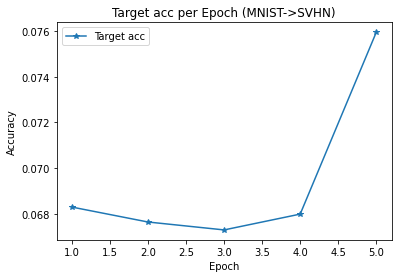

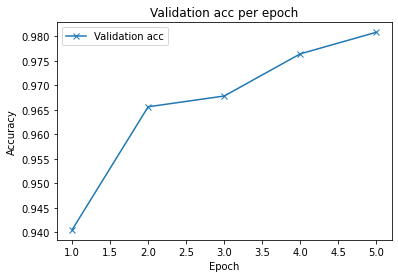

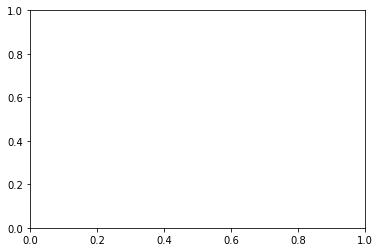

In [25]:
### plots for MNIST -> SVHN
x=[i+1 for i in range(total_epochs)]
f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
#ax.plot(x,result['val_accuracy'], 'x-')
ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (MNIST->SVHN)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("MNIST2SVHN.pdf")
#f.savefig("MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result['accuracy'], 'o-')
ax.plot(x,result['val_accuracy'], 'x-')
#ax.plot(x,result['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (MNIST->SVHN)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("MNIST2SVHN.pdf")
f.savefig("MNIST2SVHNval.pdf")



In [30]:
#print(histories2)
result2={}
for key in K:
    tmp2=[]
    for epoch in range(len(histories2)):
        tmp2.append(histories2[epoch][key])
    result2[key]=tmp2

for key in K:
    result2[key]=np.mean(result2[key],axis=0)
#print(result2)

[{'loss': [2.2314884662628174, 2.195730209350586, 1.96755850315094, 1.045084834098816, 0.7218729853630066], 'accuracy': [0.19196313619613647, 0.23250575363636017, 0.32937464118003845, 0.6751642227172852, 0.7802576422691345], 'val_loss': [2.220454692840576, 2.2083311080932617, 1.4081590175628662, 0.9109077453613281, 0.6884738802909851], 'val_accuracy': [0.2238398939371109, 0.23620928823947906, 0.5470190644264221, 0.7214966416358948, 0.7940995693206787], 'target_val_loss': [2.4606869220733643, 2.7474424839019775, 4.467350959777832, 4.940171718597412, 4.922676086425781], 'target_val_accuracy': [0.07639999687671661, 0.08669999986886978, 0.0706000030040741, 0.10329999774694443, 0.07000000029802322]}]
{'loss': array([2.23148847, 2.19573021, 1.9675585 , 1.04508483, 0.72187299]), 'accuracy': array([0.19196314, 0.23250575, 0.32937464, 0.67516422, 0.78025764]), 'val_loss': array([2.22045469, 2.20833111, 1.40815902, 0.91090775, 0.68847388]), 'val_accuracy': array([0.22383989, 0.23620929, 0.547019

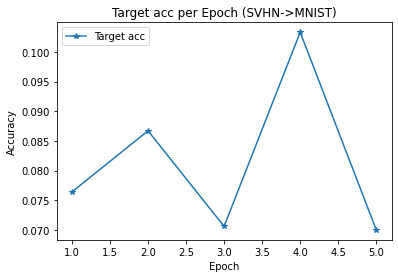

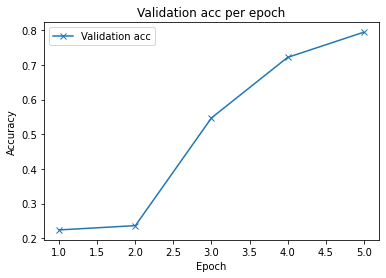

In [31]:
### plots for SVHN -> MNIST
x=[i+1 for i in range(total_epochs)]
f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
#ax.plot(x,result2['val_accuracy'], 'x-')
ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
ax.legend(['Target acc'], loc = 0)
#ax.legend(['Validation acc'], loc = 0)
ax.set_title('Target acc per Epoch (SVHN->MNIST)')
#ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
f.savefig("SVHN2MNIST.pdf")
#f.savefig("SVHN2MNISTval.pdf")

f, ax = plt.subplots()
#ax.plot(x,result2['accuracy'], 'o-')
ax.plot(x,result2['val_accuracy'], 'x-')
#ax.plot(x,result2['target_val_accuracy'], '*-')
# Plot legend and use the best location automatically: loc = 0.
#ax.legend(['Train acc', 'Validation acc','Target acc'], loc = 0)
#ax.legend(['Target acc'], loc = 0)
ax.legend(['Validation acc'], loc = 0)
#ax.set_title('Target acc per Epoch (SVHN->MNIST)')
ax.set_title('Validation acc per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
#f.savefig("SVHN2MNIST.pdf")
f.savefig("SVHN2MNISTval.pdf")